# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import LabelBinarizer
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import re
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data\\bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Явные пропуски есть в строке balance

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код

df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Есть категория unknown, благо таких значений всего 70

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def regular_float(arg):
    if type(arg)==str: # это нужно для того, чтобы не считывался нан
        result = arg.replace(',', '.').replace('$', '').replace(' ', '') # заменяем всё ненужное
        result = float(result)  # переводим тип
        return result
    else:
        pass

    
df['balance'] = df['balance'].apply(regular_float) 

Столбец баланса не считывался корректно из-за знака доллара в конце, пробела и запятой, поменяем их

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
print('Баланс до замены пропусков: ', df['balance'].mean())
df['balance'] = df['balance'].fillna(df['balance'].median())
print('Баланс до замены пропусков: ', df['balance'].mean())

Баланс до замены пропусков:  1529.1290293615875
Баланс до замены пропусков:  1526.9360329690019


### Задание 5

In [8]:
df['education'].value_counts() # выясним самое часто встречаемое (модальное значение) в образовании

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [9]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

df['job'] = df['job'].replace('unknown','management')
df['education'] = df['education'].replace('unknown', 'secondary')

In [10]:
# рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
df[(df['education'] == 'secondary') & (df['job'] == 'management')]['balance'].mean()

1598.8829787234042

### Задание 6

Нижняя граница:  -2241.0 , верхняя граница:  4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10104


Text(0.5, 1.0, 'Баланс - после очистки от выбросов')

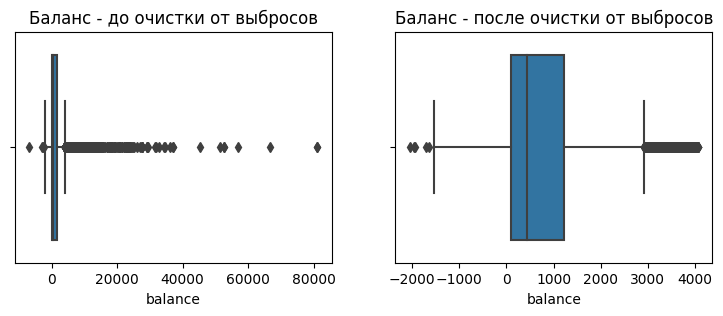

In [11]:
# удалите все выбросы для признака balance
# ваш код

# МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)
# используем функцию из курса outliers_iqr()
def outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature]) # иногда добавляется 1: x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left) #размах можно изменять под данные
    upper_bound = quartile_3 + (iqr * right) 
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    print('Нижняя граница: ', lower_bound, ', верхняя граница: ', upper_bound)
    return outliers, cleaned

# Применим эту функцию 
outliers, cleaned = outliers_iqr(df, 'balance') 
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

# визуализируем
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
boxplot_1 = sns.boxplot(data=df, x='balance', ax=axes[0])
boxplot_1.set_title('Баланс - до очистки от выбросов')
boxplot_2 = sns.boxplot(data=cleaned, x='balance', ax=axes[1])
boxplot_2.set_title('Баланс - после очистки от выбросов')


## Часть 2:  Разведывательный анализ

### Задание 1

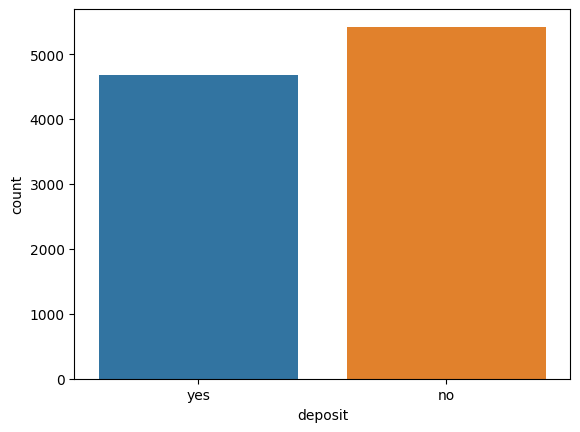

In [12]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
ax = sns.countplot(data=cleaned, x='deposit')

Данные неплохо сбалансированы, существенных перекосов нет

### Задания 2 и 3

In [13]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000
mean,40.895487,807.331354,15.590657,368.777712,2.516924,51.307700,0.816112
std,11.735511,993.673452,8.441852,346.650712,2.707180,109.643031,2.243875
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,444.500000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1224.750000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4062.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Минимальный возраст - 18 лет, учитывая, что мы говорим о финансовом секторе - это логично. Максимальный возраст - 95 - звучит немного нереалистично, хотя гипотетически возможно, что у человека был пенсионный счет и он до сих пор открыт. В столбце баланса средняя и медианная отличаются почти в 2 раза, что говорит о довольно сильном смещении в пользу небольшого баланса. Забавно, что самый длинный разговор по маркетинговой кампании длился больше часа (в целом может быть реальным). В среднем в рамках одной кампании к клиентам обращались по 2 раза, это же значение и медианное. Есть уникальные клиенты, к кому обращались 43 раза

### Задания 4 и 5

In [14]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код

cleaned.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10104,10104,10104,10104,10104,10104,10104,10104,10104,10104
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2314,5714,5517,9938,5243,8711,7282,2616,7570,5423


В основном кампания банка была проведена на семейных клиентах (более половины), имеют высшее образование (secondary) и относятся к одной из 11 профессий, из которых 1/5 часть - менеджеры. Почти ни у кого из них нет просроченных кредитов, и у более чем 80% нет потребкредитов, а вот ипотека имеется почти у половины. С более чем 70% из участников кампании связывались с помощью сотового телефона, и ранее неизвестно, участвовали ли они в подобных кампаниях или нет (poutcome = unknown). Помесячно кампания распределена была более менее равномерно, но все же большинство звонков пришлось на май.

Сводная таблицца по успехам кампании в разрезе профессии и уровня образования
job        admin.  blue-collar  entrepreneur  housemaid  management  retired   
education                                                                      
primary        41          636            36        135          60      239  \
secondary    1051         1129           145         82         336      302   
tertiary      154           42           119         35        1918      122   

job        self-employed  services  student  technician  unemployed  
education                                                            
primary               25        75       19          34          49  
secondary            131       746      238        1148         209  
tertiary             202        47       69         456          74  


Text(0.5, 1.0, 'Тепловая карта по профессиям и уровню образования и результатам кампании')

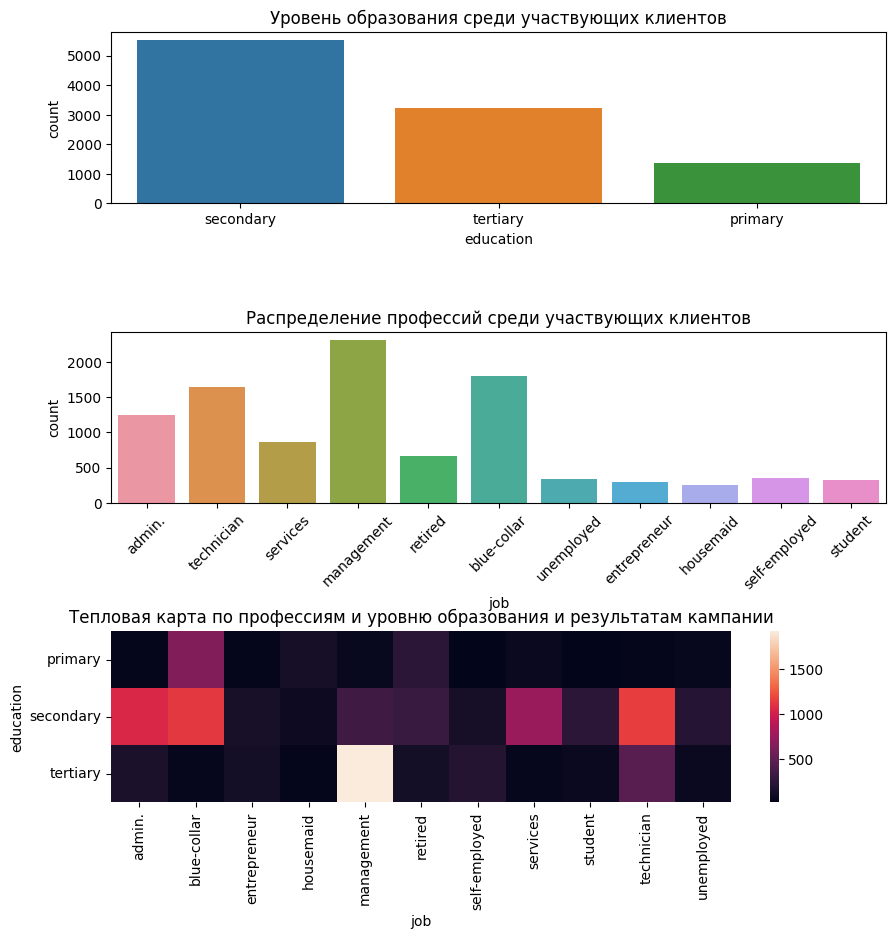

In [15]:
# постройте визуализации, иллюстрирующие результаты

# для начала сделаем сводную таблицу для тепловой карты
pivot_1 = cleaned.groupby(['education', 'job'])['deposit'].count().unstack()
print('Сводная таблицца по успехам кампании в разрезе профессии и уровня образования')
print(pivot_1)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.75) # расстояние между графиками

bars_1 = sns.countplot(data=cleaned, x='education', ax=axes[0])
bars_1.set_title('Уровень образования среди участвующих клиентов')

bars_2 = sns.countplot(data=cleaned, x='job', ax=axes[1])
bars_2.set_title('Распределение профессий среди участвующих клиентов')
bars_2.xaxis.set_tick_params(rotation = 45) # поворот названий осей для графика 

heatmap_1 = sns.heatmap(pivot_1, ax=axes[2])
heatmap_1.set_title('Тепловая карта по профессиям и уровню образования и результатам кампании')

### Задание 6

In [16]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
pivot_2 = cleaned.pivot_table(
    values='default', # по сути любое значение, чтобы посчитать
    index='poutcome',
    columns='deposit', 
    aggfunc=['count'],
    fill_value=0
)
pivot_2

count      
deposit     no   yes
poutcome            
failure    561   547
other      216   265
success     84   861
unknown   4562  3008

В категориях other и success прошлой кампании и текущая кампания оказалась более успешной. Особенно заметно по категории success

### Задание 7

In [17]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

pivot_3 = cleaned.pivot_table(
    values='default', # по сути любое значение, чтобы посчитать
    index='month',
    columns='deposit', 
    aggfunc=['count'],
    fill_value=0
)
pivot_3

count     
deposit    no  yes
month             
apr       317  513
aug       775  610
dec         9   84
feb       323  386
jan       194  125
jul       836  582
jun       606  498
mar        24  213
may      1775  841
nov       456  324
oct        62  273
sep        46  232

В мае самые низкие показатели успешной кампании

### Задание 8

In [18]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_grade(agr):
    if agr<=30: result = '<30'
    elif agr>30 and agr<=40: result = '30-40'
    elif agr>40 and agr<=50: result = '40-50'
    elif agr>50 and agr<=60: result = '50-60'
    else: result = '60+'
        
    return result

cleaned['age_group'] = cleaned['age'].apply(age_grade)

pivot_4 = cleaned.pivot_table(
    values='default', # по сути любое значение, чтобы посчитать
    index='age_group',
    columns='deposit', 
    aggfunc=['count'],
    fill_value=0
)
pivot_4

count      
deposit      no   yes
age_group            
30-40      2215  1627
40-50      1359   895
50-60       933   692
60+          97   416
<30         819  1051

Люди моложе 30 и старше 60 показывают более высокие показатели по открытию кредитов, чем по отказу от кампании

### Задания 9 и 10

Text(50.722222222222214, 0.5, 'Семейный статус')

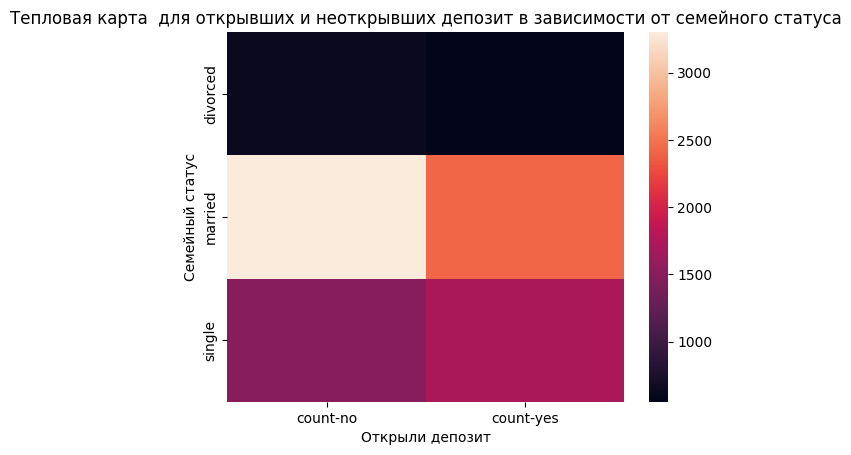

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
pivot_5 = cleaned.pivot_table(
    values='default', # по сути любое значение, чтобы посчитать
    index='marital',
    columns='deposit', 
    aggfunc=['count'],
    fill_value=0
)
pivot_5

heatmap_2 = sns.heatmap(pivot_5)
heatmap_2.set_title('Тепловая карта  для открывших и неоткрывших депозит в зависимости от семейного статуса')
heatmap_2.set_xlabel('Открыли депозит')
heatmap_2.set_ylabel('Семейный статус')

Больше всего и открывших депозит и отказавшихся в группе женатых/замужних

Text(50.722222222222214, 0.5, 'Образование')

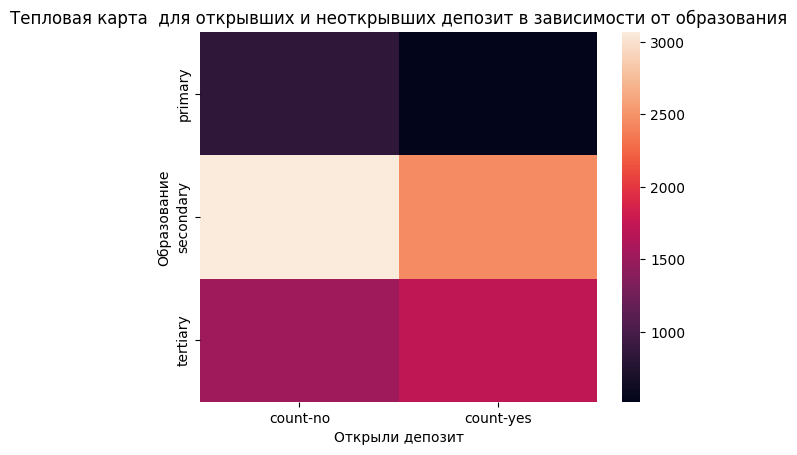

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
pivot_6 = cleaned.pivot_table(
    values='default', # по сути любое значение, чтобы посчитать
    index='education',
    columns='deposit', 
    aggfunc=['count'],
    fill_value=0
)
pivot_6

heatmap_3 = sns.heatmap(pivot_6)
heatmap_3.set_title('Тепловая карта  для открывших и неоткрывших депозит в зависимости от образования')
heatmap_3.set_xlabel('Открыли депозит')
heatmap_3.set_ylabel('Образование')

Больше всего и открывших депозит и отказавшихся в группе с высшим образованием (secondary)

Text(50.72222222222221, 0.5, 'Профессия')

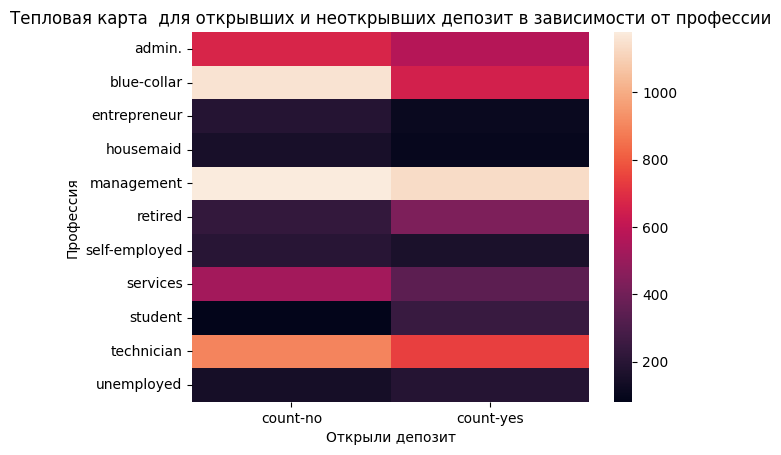

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
pivot_7 = cleaned.pivot_table(
    values='default', # по сути любое значение, чтобы посчитать
    index='job',
    columns='deposit', 
    aggfunc=['count'],
    fill_value=0
)
pivot_7

heatmap_4 = sns.heatmap(pivot_7)
heatmap_4.set_title('Тепловая карта  для открывших и неоткрывших депозит в зависимости от профессии')
heatmap_4.set_xlabel('Открыли депозит')
heatmap_4.set_ylabel('Профессия')

Больше всего опрошенных среди менеджмента, соответственно и открывших и неоткрывших среди них много. Но также много тех, кто согласился на компанию среди технических специалистов

### Задание 11

In [22]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит) - используем маску

mask = cleaned[cleaned['deposit']=='yes']

pivot_8 = mask.pivot_table(
    values='default', # по сути любое значение, чтобы посчитать
    index='education',
    columns='marital', 
    aggfunc=['count'],
    fill_value=0
)
pivot_8

count               
marital   divorced married single
education                        
primary         96     339     82
secondary      283    1289    879
tertiary       174     784    755

## Часть 3: преобразование данных

### Задание 1

In [23]:
# преобразуйте уровни образования и возрастные группы
label_encoder = LabelEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_label_education = label_encoder.fit_transform(cleaned['education'])
data_label_education = pd.DataFrame(data_label_education, columns=['education_cod'])
data_label_age_group = label_encoder.fit_transform(cleaned['age_group'])
data_label_age_group = pd.DataFrame(data_label_age_group, columns=['age_group_cod'])

data_label_education.sum()

education_cod    11993
dtype: int64

### Задания 2, 3, 4

In [24]:
cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50


In [25]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# создайте дамми-переменные - объединим эти 2 пункта

# преобразуем бинарные переменные в представление из нулей и единиц
columns_to_change = ['housing', 'default', 'loan', 'deposit'] 
# запишем функцию 
for column in columns_to_change: # использовать один раз!!!!
    cleaned[column] = cleaned[column].apply(lambda x: 1 if x =='yes' else 0)

display(cleaned)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,50-60
1,56,admin.,married,secondary,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,50-60
2,41,technician,married,secondary,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,40-50
3,55,services,married,secondary,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,50-60
4,54,admin.,married,tertiary,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,30-40
11158,39,services,married,secondary,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,30-40
11159,32,technician,single,secondary,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,30-40
11160,43,technician,married,secondary,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,40-50


In [26]:
cleaned['deposit'].std()
cleaned['housing'].mean()+cleaned['default'].mean()+cleaned['loan'].mean()
cleaned = cleaned.reset_index() # иначе contact сбивается и добавляет строки

In [27]:
# объединим наш массив с предыдущими двумя признаками
data_new = pd.concat([cleaned, data_label_education, data_label_age_group], axis=1)
data_new.drop(['education', 'age_group', 'index'],axis=1,inplace=True)
data_new

,age,job,marital,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,education_cod,age_group_cod
0,59,admin.,married,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,1,2
1,56,admin.,married,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,1,2
2,41,technician,married,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1,1
3,55,services,married,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,1,2
4,54,admin.,married,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10099,33,blue-collar,single,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,0,0
10100,39,services,married,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,1,0
10101,32,technician,single,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,1,0
10102,43,technician,married,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,1,1


In [28]:
# займемся дамми-переменными
data_new = pd.get_dummies(data_new)
data_new

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343.0,1,0,5,1042,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
1,56,0,45.0,0,0,5,1467,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
2,41,0,1270.0,1,0,5,1389,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
3,55,0,2476.0,1,0,5,579,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
4,54,0,184.0,0,0,5,673,2,-1,0,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10099,33,0,1.0,1,0,20,257,1,-1,0,...,False,False,False,False,False,False,False,False,False,True
10100,39,0,733.0,0,0,16,83,4,-1,0,...,True,False,False,False,False,False,False,False,False,True
10101,32,0,29.0,0,0,19,156,2,-1,0,...,False,False,False,False,False,False,False,False,False,True
10102,43,0,0.0,0,1,8,9,2,172,5,...,False,False,True,False,False,False,True,False,False,False


### Задания 5 и 6

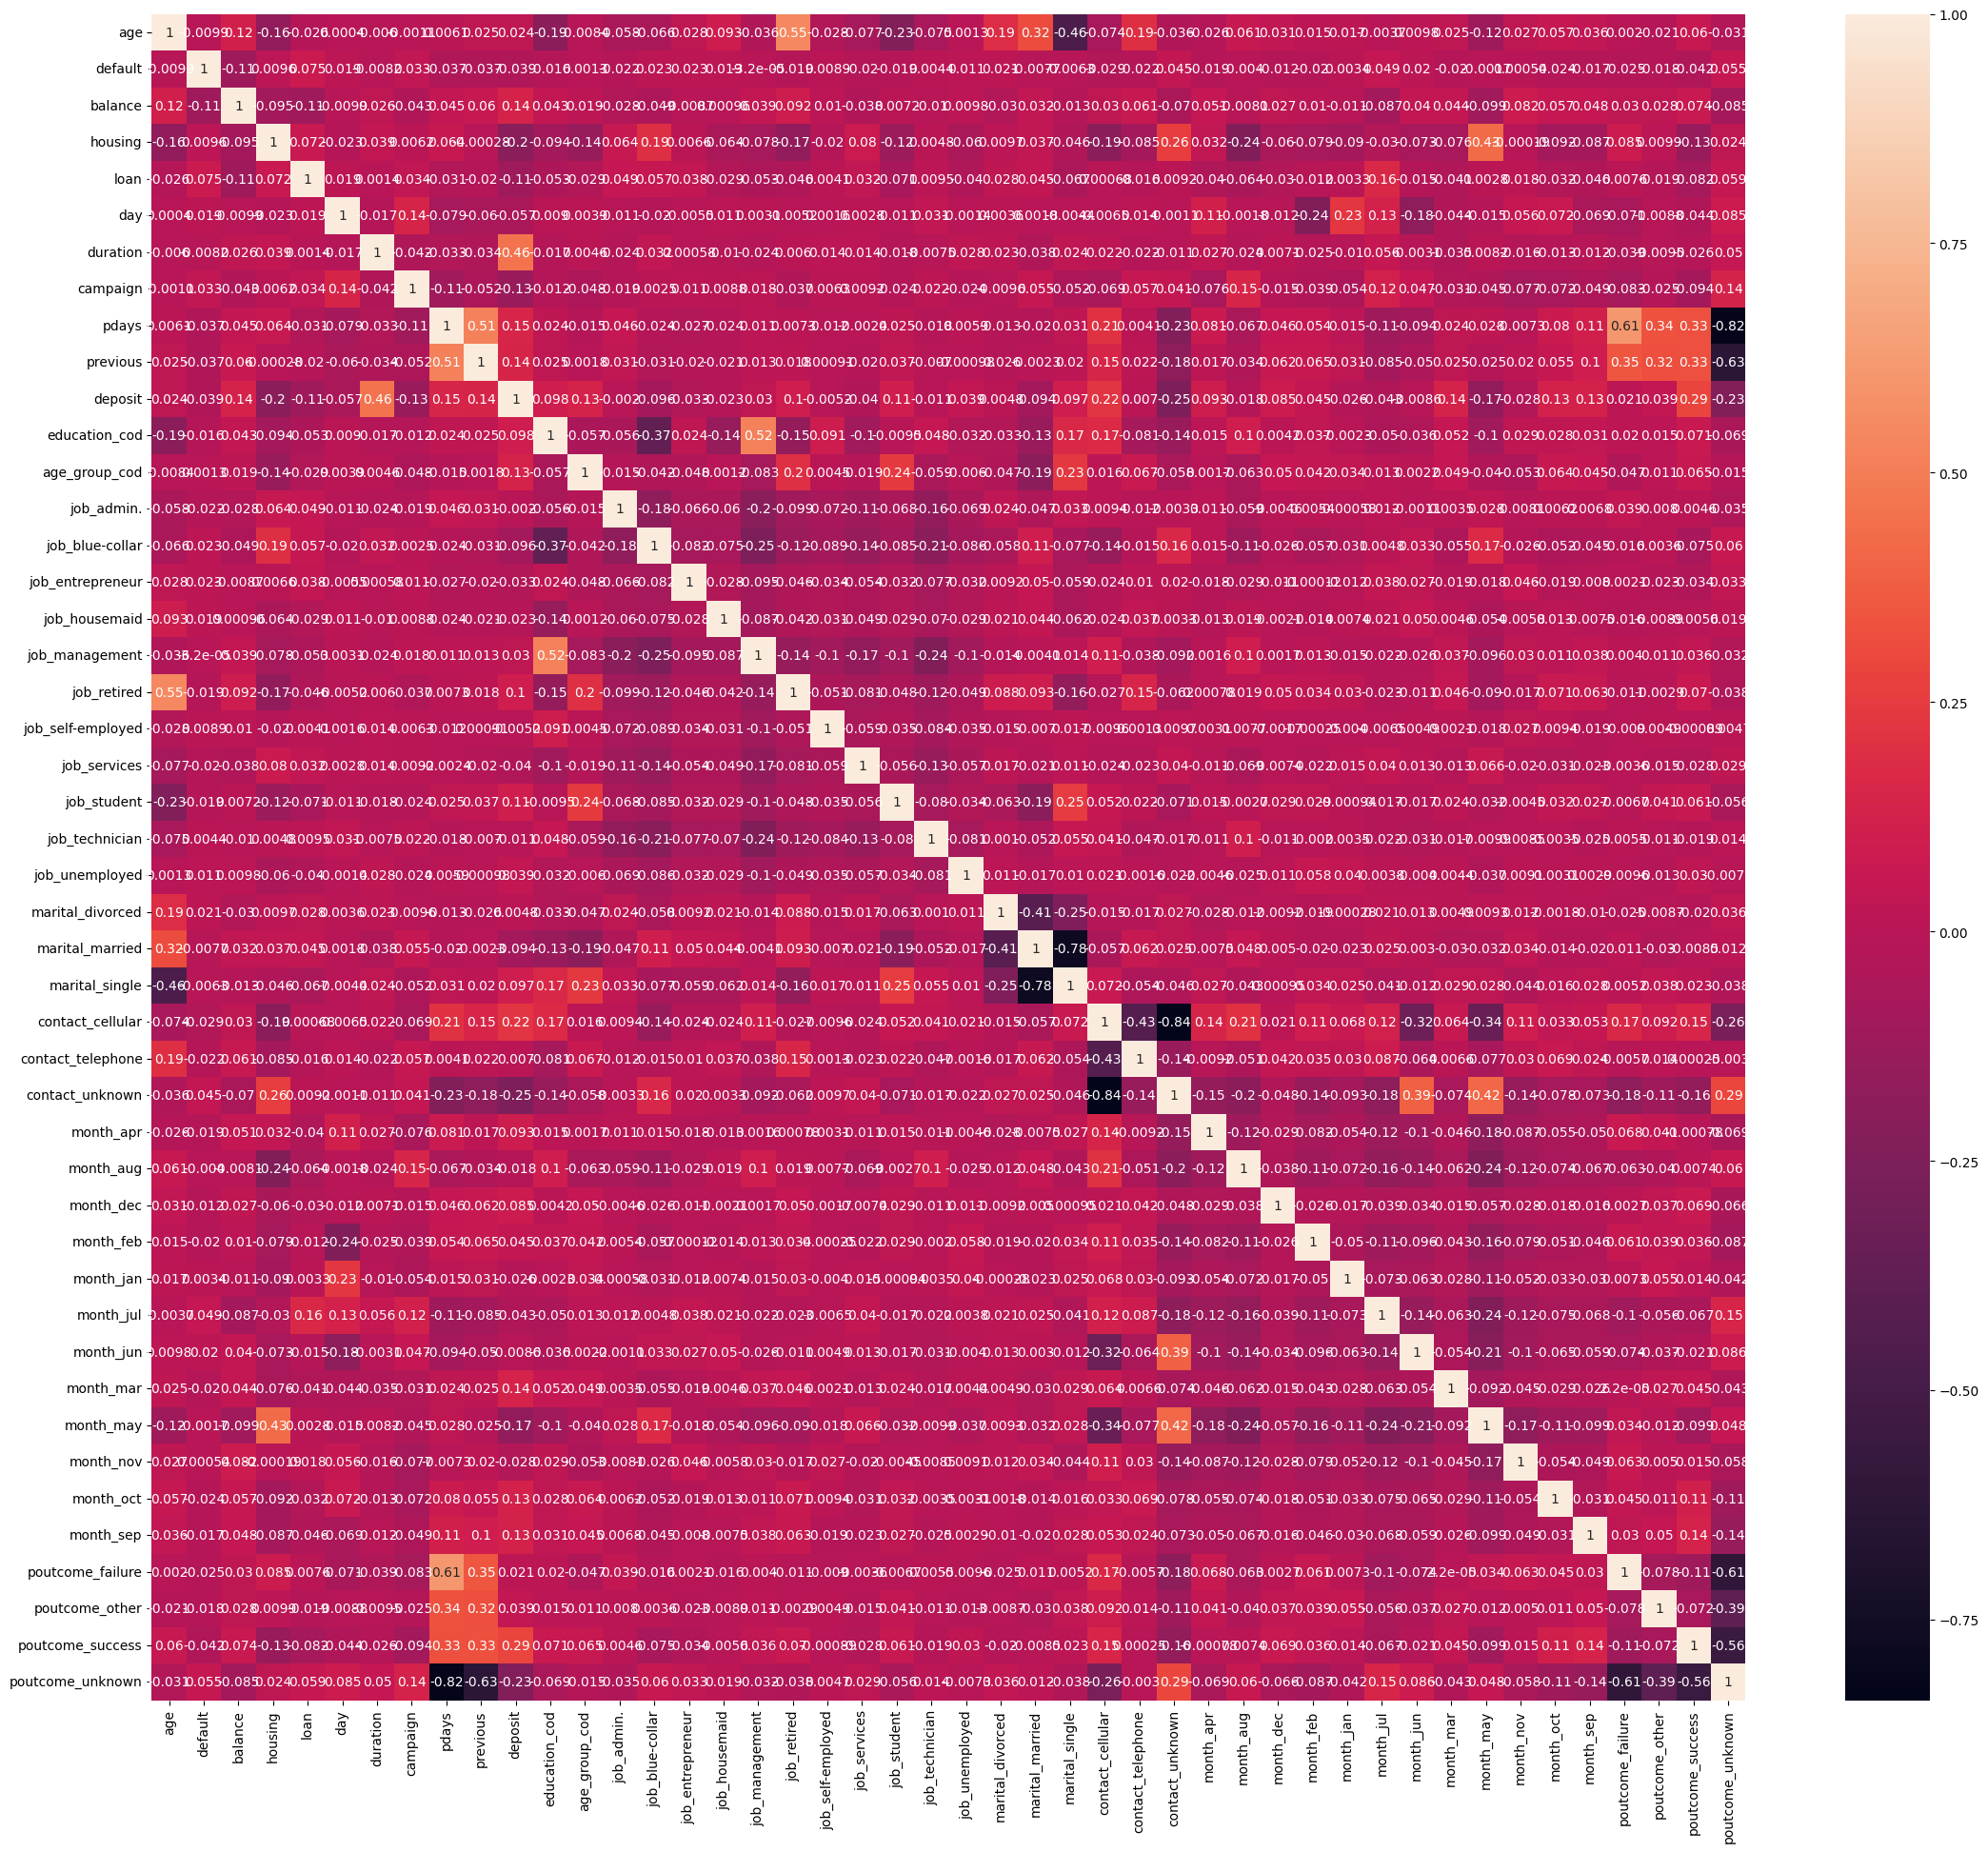

In [29]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(27,23))
fig = sns.heatmap(data_new.corr(), annot = True)

Есть признаки, которые имеют достаточно высокую кросс-корреляцию (типа pdays\poutcome_unknown или contact_cellulat\contact_unknown) но она ниже 90%, с целевым же признаком корреляция не превышает 50%

### Задания 7 и 8

In [30]:
X = data_new.drop(['deposit'], axis=1)
y = data_new['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)


In [31]:
# рассчитайте необходимые показатели
X_test
y_test.mean()

0.46326836581709147

### Задание 9

In [32]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(k=15, score_func = f_classif)
selector.fit(X_train, y_train)
 
columns = selector.get_feature_names_out()
columns

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group_cod', 'contact_cellular', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'month_sep',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

In [33]:
data_15 = data_new[columns]
data_15

# пересобираем по отобранным признакам
X = data_15
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [34]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
display(X_test_scaled)

array([[0.36077918, 0.        , 0.07424594, ..., 0.        , 1.        ,
        0.        ],
       [0.33835325, 0.        , 0.05259087, ..., 0.        , 0.        ,
        1.        ],
       [0.36405304, 0.        , 0.04253674, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.60697332, 1.        , 0.03042021, ..., 0.        , 0.        ,
        1.        ],
       [0.54951711, 0.        , 0.08275329, ..., 0.        , 0.        ,
        1.        ],
       [0.36896382, 0.        , 0.04588812, ..., 0.        , 1.        ,
        0.        ]])

In [36]:
X_test_scaled[ : ,0].mean() # нулевой элемент каждого подмассива

0.4677009833600142

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [37]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [38]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3633
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6769
   macro avg       0.82      0.82      0.82      6769
weighted avg       0.82      0.82      0.82      6769

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



accuracy составляет 0.81, а F1 на тестовой выборке 78% - неплохие результаты, но можно лучше

### Задания 2,3,4

In [39]:
# обучите решающие деревья, настройте максимальную глубину

#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', # по дефолту gini
    random_state=42
)

#Обучаем дерево 
dt.fit(X_train_scaled, y_train)

#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('accuracy на тренинговом наборе:  {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('accuracy на тестовом наборе:  {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

accuracy на тренинговом наборе:  1.00
accuracy на тестовом наборе:  0.76


accuracy на тренинговой выборке в 100% - явный признак переобучения

### Задание 5

In [40]:
# подберите оптимальные параметры с помощью gridsearch

# задаем сетку: 
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,6,7]}
grid_search = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=5, #количество фолдов кросс-валидации
    n_jobs = -1 #используем все ядра
) 
# тут выбирается наилучший набор на основе стандартной метрики accuracy 
%time grid_search.fit(X_train_scaled, y_train) 

# по умолчанию в методе .score идут accuracy_score для классификации и r2_score для регрессии. 
# Альтернативную функцию оценки можно указать с помощью параметра оценки большинства инструментов поиска параметров: metrics.f1_score, metrics.recall_score
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test))) # нестандартный код потому что используется лучшая модель, 
# т.е. мы еще до предсказания смотрим насколько по данным Х тестовой выборки выдаются корректные Y
# а тут уже используется лучшая модель для предсказывания
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 312 ms
Wall time: 4.93 s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [41]:
# обучите на ваших данных случайный лес (бэггинг - 1ый вид построения ансамблей)

#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
            n_estimators = 100,
            criterion = 'gini',
            min_samples_leaf = 5,
            max_depth = 10,
            random_state = 42
            )
#Обучаем дерево по алгоритму CARTrint
rf.fit(X_train_scaled, y_train)

#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('accuracy на тренировочном наборе:  {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('recall на тренировочном наборе:  {:.3f}'.format(metrics.recall_score(y_train, y_train_pred)))

y_test_pred = rf.predict(X_test_scaled)
#print(classification_report(y_test, y_pred))
print('accuracy на тестовом наборе:  {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('recall на тестовом наборе:  {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1 на тестовом наборе:  {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тренировочном наборе:  0.859
recall на тренировочном наборе:  0.865
accuracy на тестовом наборе:  0.828
recall на тестовом наборе:  0.833
f1 на тестовом наборе:  0.817


### Задания 2 и 3

In [42]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом (бустинг - 2ой метод построения ансамблей)

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42 
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки

# Посмотрим на основные метрики классификации
y_train_pred = rf.predict(X_train_scaled)
print('accuracy на тренировочном наборе:  {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('recall на тренировочном наборе:  {:.3f}'.format(metrics.recall_score(y_train, y_train_pred)))

y_test_pred  = gb.predict(X_test_scaled)
#print(classification_report(y_test, y_test_pred))
print('accuracy на тестовом наборе:  {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('recall на тестовом наборе:  {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1 на тестовом наборе:  {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тренировочном наборе:  0.859
recall на тренировочном наборе:  0.865
accuracy на тестовом наборе:  0.826
recall на тестовом наборе:  0.833
f1 на тестовом наборе:  0.816


Совсем немного, но случайный лес дает лучшие результаты

### Задание 4

In [43]:
# объедините уже известные вам алгоритмы с помощью стекинга (Стекинг — 3ий метод построения ансамблей:
# параллельно обучаем множество разных моделей, отправляем их результаты в финальную модель, и уже она принимает решение)

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', log_reg), # логистическая регрессия
    ('rf',  rf), # слуйчаный лес
    ('gb',  gb) # градиентный бустинг
]

# Создаем объект класса стекинг
cfl = StackingClassifier( # не StackingRegressor потому что задача классификации
    estimators=estimators,
    final_estimator=log_reg # метамодель - т.е. результирующая
)
# Обучаем модель
cfl.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_test_pred = cfl.predict(X_test_scaled)

print(classification_report(y_test, y_test_pred))
print('accuracy на тестовом наборе:  {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('recall на тестовом наборе:  {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1 на тестовом наборе:  {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

accuracy на тестовом наборе:  0.825
recall на тестовом наборе:  0.818
f1 на тестовом наборе:  0.812


### Задание 5

In [44]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = gb
selector = RFE(estimator, n_features_to_select=1, step=1) # запишем n_features_to_select=1 чтобы была точная градация признаков от 1 до 15 
#(иначе в selector.ranking_ все выбранные признаки будут за 1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration'], dtype=object)

In [45]:
# выведем столбцы
X_train.columns

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group_cod', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [46]:
# и их рэнкинг
selector.ranking_

array([ 3,  6,  1, 11,  5, 13,  7, 14,  4,  8, 10,  9, 12,  2, 15])

### Задания 6,7,8

In [47]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

# начнем с функции
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1),
  max_depth = trial.suggest_int('max_depth', 10, 30, 1),
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = rf
  # обучаем модель
  model.fit(X_train_scaled, y_train) 
  #score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean() #попробуем с кросс-валидацией
  score = metrics.f1_score(y_train, model.predict(X_train_scaled)) #без кросс-валидации

  return score

In [48]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2023-09-07 21:45:12,914] A new study created in memory with name: RandomForestClassifier
[I 2023-09-07 21:45:14,201] Trial 0 finished with value: 0.8500235072872591 and parameters: {'n_estimators': 184, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8500235072872591.
[I 2023-09-07 21:45:15,541] Trial 1 finished with value: 0.8500235072872591 and parameters: {'n_estimators': 124, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8500235072872591.
[I 2023-09-07 21:45:16,872] Trial 2 finished with value: 0.8500235072872591 and parameters: {'n_estimators': 132, 'max_depth': 24, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8500235072872591.
[I 2023-09-07 21:45:18,031] Trial 3 finished with value: 0.8500235072872591 and parameters: {'n_estimators': 129, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8500235072872591.
[I 2023-09-07 21:45:19,256] Trial 4 finished with value: 0.8500235072872591 and parameters: {'n_

CPU times: total: 35.8 s
Wall time: 37.4 s


In [49]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 184, 'max_depth': 12, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.85


In [50]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, criterion = 'gini', random_state=42) #дописываем гипермараметры, которые были в модели, но мы их не меняли
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.827
f1_score на тестовом наборе: 0.818
